# Finetuning Gemma 2 using Unsloth

This notebook demonstrates how to finetune the `Gemma 2 (2B)` LLM using the Unsloth framework. It includes:
- Setting up and installing required dependencies.
- Loading datasets and configuring training parameters.
- Performing supervised fine-tuning (SFT).
- Saving the model and optionally exporting to Ollama.


In [ ]:
!pip install -q unsloth datasets transformers accelerate bitsandbytes peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Library Imports
- Import essential modules such as `datasets`, `SFTTrainer`, `TrainingArguments`, and `torch`.
- These modules are necessary for training and preparing datasets using Unsloth's SFT pipeline.


In [ ]:
# Import libraries
from datasets import load_dataset
from unsloth.trainer import SFTTrainer
from transformers import TrainingArguments
import torch

### Model Loading
- Load the `Gemma 2B` model and tokenizer using `FastLanguageModel` from Unsloth.
- This sets up the pretrained model architecture required for fine-tuning.


In [ ]:
from unsloth import FastLanguageModel
# Load Gemma 9B with Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/gemma-2b-it",
    max_seq_length=2048,
    dtype=torch.float16,
    load_in_4bit=True,
)

==((====))==  Unsloth 2025.3.19: Fast Gemma patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.07G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

### Dataset Loading
- Load the training dataset using Hugging Face `datasets` library.
- This dataset will be formatted and used to train the LLM model.


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("squad")

# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples["context"], examples["question"], truncation=True, padding="max_length", max_length=2048)

# Apply the tokenization function to the dataset
dataset = dataset.map(tokenize_function, batched=True)

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
# Ensure formatting
def formatting_func(example):
    context = example.get("context", "")
    question = example.get("question", "")

    try:
        if isinstance(example["answers"], dict):
            answer_list = example["answers"].get("text", [])
        elif isinstance(example["answers"], list):
            answer_list = example["answers"][0].get("text", []) if example["answers"] else []
        else:
            answer_list = []

        answer = answer_list[0] if answer_list else "No answer"
    except Exception as e:
        answer = "No answer"

    # Return a list containing the formatted string
    return [f"""Context: {context}
Question: {question}
Answer: {answer}"""]

### Training Configuration
- Configure training arguments such as batch size, epochs, logging, and save strategy.
- These settings control the behavior and efficiency of the training process.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

Unsloth: Already have LoRA adapters! We shall skip this step.


### Trainer Initialization
- Initialize the `SFTTrainer` with model, tokenizer, dataset, and training arguments.
- This wraps the training logic and prepares the model for fine-tuning.


In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset["train"],
    formatting_func=formatting_func,
    dataset_text_field=None,
    max_seq_length=2048,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=100,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=10,
        save_steps=200,
        output_dir="qa_outputs",
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        report_to="none",
    ),
)

### Start Training
- Begin the fine-tuning process using the initialized `SFTTrainer`.
- Model learns from the dataset by minimizing training loss.


In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 87,599 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 19,611,648/2,000,000,000 (0.98% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,12.820500
20,12.190700
30,10.395300
40,9.431400
50,8.992200
60,9.275300
70,9.359000
80,9.144800
90,8.798300
100,8.680900


TrainOutput(global_step=100, training_loss=9.908836288452148, metrics={'train_runtime': 1447.9285, 'train_samples_per_second': 0.553, 'train_steps_per_second': 0.069, 'total_flos': 1.96755069075456e+16, 'train_loss': 9.908836288452148})

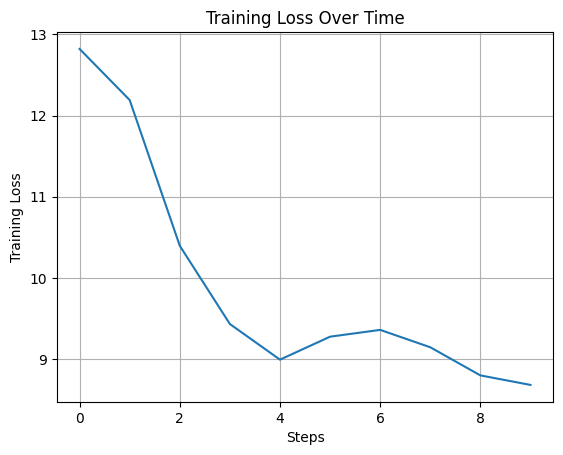

In [ ]:
import matplotlib.pyplot as plt

# Assuming `trainer` is your SFTTrainer instance
logs = trainer.state.log_history
losses = [entry['loss'] for entry in logs if 'loss' in entry]
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


In [ ]:
# Save the final fine-tuned model and tokenizer
save_path = "fine-tuned-gemma2"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer successfully saved to: {save_path}")


Model and tokenizer successfully saved to: fine-tuned-gemma2
